# Определение перспективного тарифа для телеком-компании

**Описание проекта**

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюдже нужно понять, какой тариф приносит больше денег. Для этого проведем предварительный анализ тарифов на небольшой выборке клиентов (500 пользователей «Мегалайна») за 2018 год.

# Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from scipy import stats as st

Загрузим и посмотрим данные.

In [3]:
try:
    tariffs = pd.read_csv(url + 'tariffs.csv')
    users = pd.read_csv(url + 'users.csv')
    internet = pd.read_csv(url + 'internet.csv', index_col=0)
    calls = pd.read_csv(url + 'calls.csv')
    messages = pd.read_csv(url + 'messages.csv')
except:
    print('Не удалось загрузить файл, проверьте путь.')

In [4]:
dfs = {'tariffs':tariffs,
       'users':users,
       'internet':internet,
       'calls':calls,
       'messages':messages,
}

# Выведем данные по всем датафреймам
for df_name, df in dfs.items():
    print('\n')
    print('>>>','\t',df_name.upper())
    display(df.sample(2))
    df.info()



>>> 	 TARIFFS


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


>>> 	 USERS


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
481,1481,70,NaN,Москва,Клавдия,Чижова,2018-02-26,smart
290,1290,68,NaN,Нижний Новгород,Арсений,Безруков,2018-05-11,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


>>> 	 INTERNET


,id,mb_used,session_date,user_id
83346,1282_420,534.34,2018-09-22,1282
46711,1160_3,155.35,2018-08-03,1160


<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


>>> 	 CALLS


,id,call_date,duration,user_id
131079,1335_556,2018-11-10,13.10,1335
77173,1193_435,2018-02-07,2.43,1193


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


>>> 	 MESSAGES


,id,message_date,user_id
78266,1330_292,2018-11-28,1330
104341,1424_194,2018-12-30,1424


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


## Выводы
1. Пропуски в churn_date, в соответсвии с описанием означают что пользователь продолжает использовать тариф.
2. reg_date, session_date, call_date, message_date нужно перевести в datatime формат.

# Подготовка данных

In [5]:
# Изменим формат. Используем [M], так как разбивать будем по месяцам и данные по дням не нужны.
users.reg_date = users.reg_date.astype('datetime64[M]')
internet.session_date = internet.session_date.astype('datetime64[M]')
calls.call_date = calls.call_date.astype('datetime64[M]')
messages.message_date = messages.message_date.astype('datetime64[M]')

Проверим наличие явных дубликатов.

In [6]:
for df_name, df in dfs.items():
    for column in df.columns:
        if column == 'id':
            print(f'Число дубликатов в {df_name}.id:', df[column].duplicated().mean())
            # df[column].drop_duplicates(inplace=True)

Число дубликатов в internet.id: 0.0
Число дубликатов в calls.id: 0.0
Число дубликатов в messages.id: 0.0


Проверим наличие не явных дубликатов в названиях населенных пунктов и именах тарифов.

In [7]:
np.sort(users.city.unique())

array(['Архангельск', 'Астрахань', 'Балашиха', 'Барнаул', 'Белгород',
       'Брянск', 'Владивосток', 'Владикавказ', 'Владимир', 'Волгоград',
       'Волжский', 'Вологда', 'Воронеж', 'Грозный', 'Екатеринбург',
       'Иваново', 'Ижевск', 'Иркутск', 'Казань', 'Калининград', 'Калуга',
       'Кемерово', 'Киров', 'Кострома', 'Краснодар', 'Красноярск',
       'Курган', 'Курск', 'Липецк', 'Магнитогорск', 'Махачкала', 'Москва',
       'Мурманск', 'Набережные Челны', 'Нижневартовск', 'Нижний Новгород',
       'Нижний Тагил', 'Новокузнецк', 'Новороссийск', 'Новосибирск',
       'Омск', 'Оренбург', 'Орёл', 'Пенза', 'Пермь', 'Петрозаводск',
       'Подольск', 'Ростов-на-Дону', 'Рязань', 'Самара',
       'Санкт-Петербург', 'Саранск', 'Саратов', 'Севастополь', 'Смоленск',
       'Сочи', 'Ставрополь', 'Стерлитамак', 'Сургут', 'Тамбов', 'Тверь',
       'Тольятти', 'Томск', 'Тула', 'Тюмень', 'Улан-Удэ', 'Ульяновск',
       'Уфа', 'Хабаровск', 'Химки', 'Чебоксары', 'Челябинск', 'Череповец',
       'Чи

In [8]:
users.tariff.unique()

array(['ultra', 'smart'], dtype=object)

Построим диаграммы размаха для calls.duration и users.age.

<AxesSubplot:ylabel='Density'>

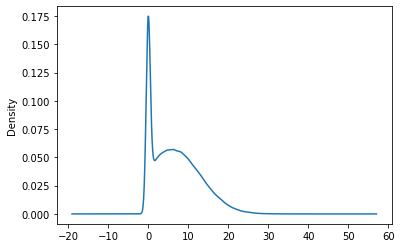

In [9]:
calls['duration'].plot.density()

<AxesSubplot:ylabel='Density'>

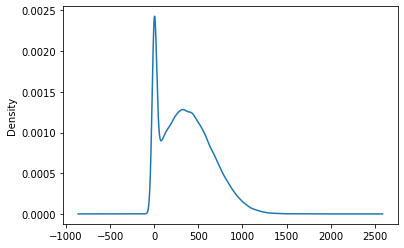

In [10]:
internet['mb_used'].plot.density()

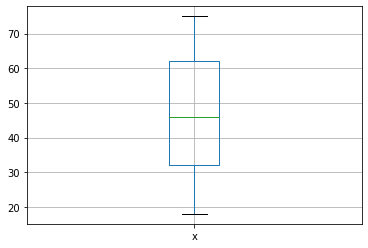

In [11]:
pd.plotting.boxplot(users.age);

У длительности звонков и количества использованных гигабайт есть смещение вправо и множество выбросов после 25 минуты и 1.1GB соответственно, в то время как по возрасту получилось близкое к нормальному распределение.

## Сортировка данных

*Все данные даны только за 2018 год, поэтому группируем их по месяцам без учета года.*

Сгруппируем суммарный веб трафик по месяцам и уникальным id пользователя.

In [12]:
internet_mounth = internet.groupby(['user_id', internet.session_date.dt.month]) \
                        .agg(gb_used=('mb_used', 'sum')) \
                        .reset_index() \
                        .rename(columns={'session_date':'month'})

Округлим гигабайты в большую сторону.

In [13]:
internet_mounth.gb_used = np.ceil(internet_mounth.gb_used/1024).astype(int)

In [14]:
print(internet_mounth.shape)
internet_mounth.head()

(3203, 3)


,user_id,month,gb_used
0,1000,5,3
1,1000,6,23
2,1000,7,14
3,1000,8,14
4,1000,9,15


Округлим звоноки до 1 минуты.

In [15]:
calls.duration = np.ceil(calls.duration).astype(int)

Определим количество сделанных звонков и число израсходованных минут разговора по месяцам.

In [16]:
calls_mounth = calls.groupby(['user_id', calls.call_date.dt.month]) \
                    .agg(calls_count=('duration', 'count'), calls_mins=('duration', 'sum')) \
                    .reset_index() \
                    .rename(columns={'call_date':'month'})

In [17]:
print(calls_mounth.shape)
calls_mounth.head()

(3174, 4)


,user_id,month,calls_count,calls_mins
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466


Подсчитаем количество отправленных сообщений по месяцам.

In [18]:
messages_mounth = messages.groupby(['user_id', messages.message_date.dt.month]) \
                        .agg(sms_sent=('user_id', 'count')) \
                        .reset_index() \
                        .rename(columns={'message_date':'month'})

In [19]:
print(messages_mounth.shape)
messages_mounth.head()

(2717, 3)


,user_id,month,sms_sent
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


Как видно часть пользователей не используют все доступные услуги.

In [20]:
print('Уникальных пользовательских id:',len(users.user_id.unique()))
print('Число пользователей, использующих интернет:',len(internet_mounth.user_id.unique()))
print('Число пользователей, использующих телефон:',len(calls_mounth.user_id.unique()))
print('Число пользователей, использующих sms-сообщения:',len(messages_mounth.user_id.unique()))

Уникальных пользовательских id: 500
Число пользователей, использующих интернет: 497
Число пользователей, использующих телефон: 492
Число пользователей, использующих sms-сообщения: 426


Найдем подозрительных пользователей, которые не используют услуги оператора.

In [21]:
# Проходимся по списку пользователей, отбирая только тех которые отсутствуют в датафреймах internet_mounth, calls_mounth и messages_mounth.
strange_ids = [id_ for id_ in users.user_id.unique()
               if (id_ not in internet_mounth.user_id.unique()) &
               (id_ not in calls_mounth.user_id.unique()) &
               (id_ not in messages_mounth.user_id.unique())
]

Оба абонента использовали свой тариф меньше месяца, так и не воспользовавшись услугами оператора, удаляем их.

In [22]:
users[users.user_id.isin(strange_ids)]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-01,ultra
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-01,smart


In [23]:
users = users.query('user_id not in @strange_ids').reset_index(drop=True)

## Объединение данных

Создадим новый столбец в tariffs, так как нас интересуют гигабайты трафика.

In [24]:
tariffs['gb_per_month_included'] = (tariffs.mb_per_month_included/1024).astype(int)
tariffs.drop(columns='mb_per_month_included', inplace=True)

Определим гендер абонентов чтобы в будущем посмотреть как отличается использование услуг у мужчин и женщин.

In [25]:
# Женские имена преимущественно оканчиваются на 'а' или 'я', этим можно воспользоваться для определения гендера.
# Ищем совпадения - слово должно состоять из последовательности букв и не заканчиваться на "а" или "я".
users['sex'] = users.first_name.map(lambda x: 'm' if bool(re.match(r'\w+[^ая]\Z', x)) else 'f')

In [26]:
users[users.first_name.isin(['Слава','Илья'])]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,sex
303,1304,68,NaN,Владимир,Илья,Соловьёв,2018-11-01,ultra,f


In [27]:
users.loc[users.first_name.isin(['Слава','Илья']),'sex'] = 'm'

In [28]:
# Проверим результат.
users.groupby('first_name')['sex'].unique().reset_index().transpose()

,0,1,2,3,4,5,6,7,8,9,...,236,237,238,239,240,241,242,243,244,245
first_name,Авксентий,Агата,Агафья,Агнесса,Адам,Аким,Аксён,Алан,Алевтина,Александр,...,Эльмира,Эмилия,Эсмеральда,Юзефа,Юлий,Юлия,Юна,Юрий,Яков,Яна
sex,[m],[f],[f],[f],[m],[m],[m],[m],[f],[m],...,[f],[f],[f],[f],[m],[f],[f],[m],[m],[f]


Разделим пользователей на возрастные группы.

In [29]:
bins = [users.age.min(), 35, 55, users.age.max()]
labels = ['young', 'mature', 'old']
users['age_group'] = pd.cut(users.age, bins=bins, labels=labels, include_lowest=True).astype(object)

Сгруппируем все услуги.

In [30]:
# Используем метод 'outer' чтобы не потерять часть данных.
combo_df = internet_mounth.set_index(['user_id','month']) \
                          .join(other=[calls_mounth.set_index(['user_id','month']),
                                       messages_mounth.set_index(['user_id','month'])],
                                how='outer').reset_index()
combo_df.head()

,user_id,month,gb_used,calls_count,calls_mins,sms_sent
0,1000,5,3.0,22.0,159.0,22.0
1,1000,6,23.0,43.0,172.0,60.0
2,1000,7,14.0,47.0,340.0,75.0
3,1000,8,14.0,52.0,408.0,81.0
4,1000,9,15.0,58.0,466.0,57.0


Добавим информацию по тарифам и пользователям.

In [31]:
# Добавим в датафрейм данные из users, а затем получив имя тарифа из tariffs.
# В результате объединения получатся идентичные столбцы, поэтому удалим tariff_name.
combo_df = combo_df.merge(users[['age_group','city','tariff','sex','user_id']], on='user_id') \
                   .merge(tariffs, left_on='tariff', right_on='tariff_name') \
                   .drop(columns='tariff_name') \
                   .reset_index(drop=True)

После объединения 'outer' должны были образовать NaN. Заполним их нулями из предположения что пользователь не использовал определённые услуги.

In [32]:
combo_df.fillna(0, inplace=True)

# Выводим окончательный датафрейм:
combo_df.sample(5)

,user_id,month,gb_used,calls_count,calls_mins,sms_sent,age_group,city,tariff,sex,messages_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included
2921,1433,5,14.0,76.0,554.0,94.0,old,Подольск,smart,f,50,500,550,200,3,3,15
2824,1418,12,19.0,64.0,413.0,54.0,young,Новосибирск,smart,m,50,500,550,200,3,3,15
810,1402,11,20.0,104.0,742.0,25.0,young,Пенза,ultra,f,1000,3000,1950,150,1,1,30
825,1412,8,37.0,115.0,845.0,43.0,old,Волгоград,ultra,m,1000,3000,1950,150,1,1,30
2619,1372,2,10.0,62.0,560.0,29.0,old,Магнитогорск,smart,f,50,500,550,200,3,3,15


## Помесячная выручка с каждого пользователя

In [33]:
# Вычитаем из израсходованных услуг бесплатный объем входящий в тариф, после чего умножаем на clip чтобы
# не образовалось отрицательных значений, затем умножаем на стоимость единичной услуги и прибавляем абонентскую плату.
combo_df['profit'] = (combo_df.gb_used - combo_df.gb_per_month_included).clip(lower=0) * combo_df.rub_per_gb + \
                     (combo_df.calls_mins - combo_df.minutes_included).clip(lower=0) * combo_df.rub_per_minute + \
                     (combo_df.sms_sent - combo_df.messages_included).clip(lower=0) * combo_df.rub_per_message + \
                     combo_df.rub_monthly_fee

## Выводы
1. Проведена проверка на наличие дубликатов.
2. Удалены абоненты, не воспользовавшиеся услугами оператора.
3. Объединены данные из датафреймов. Выполнена группировка по ID и месяцам.
4. Найдена помесячная выручка с каждого пользователя.

# Анализ данных

## Гистограммы для разных наборов параметров

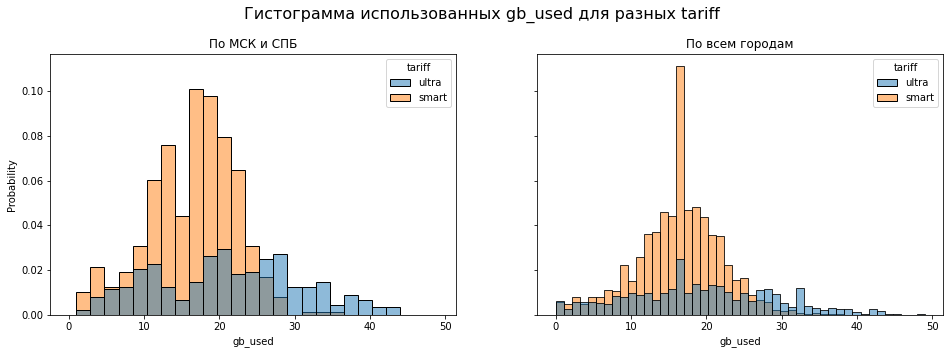

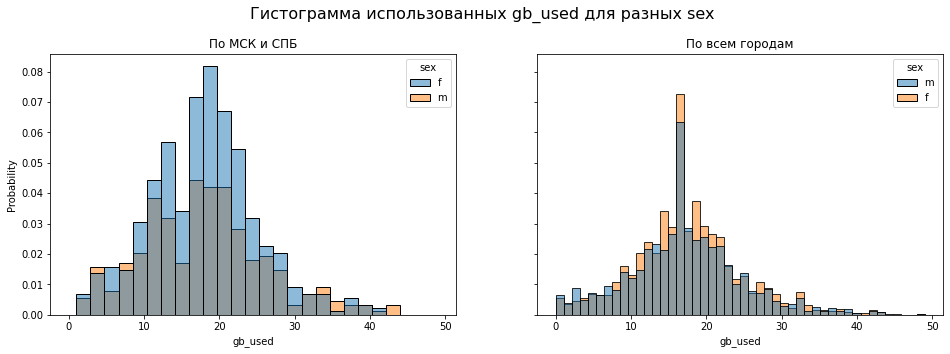

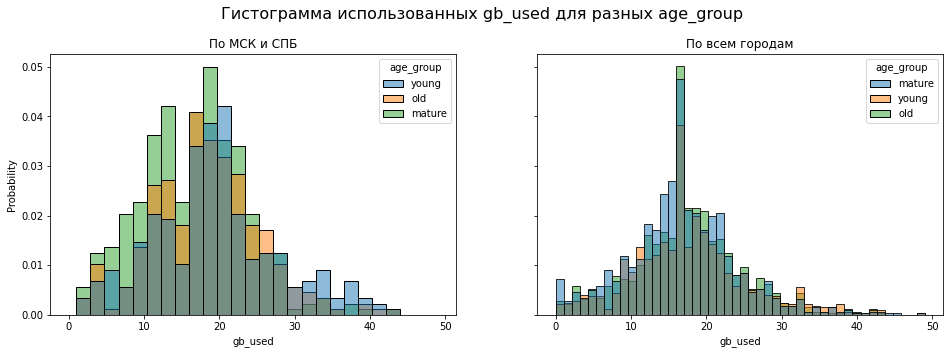

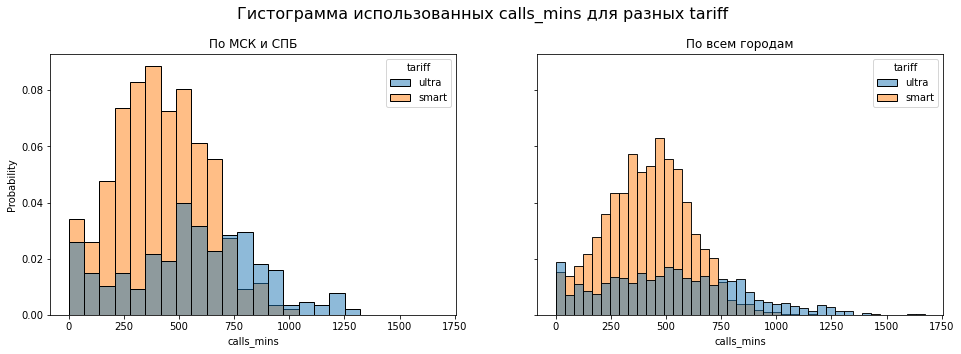

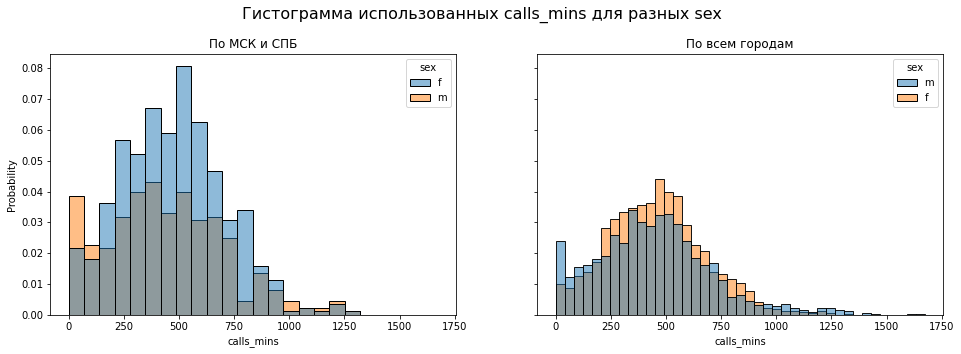

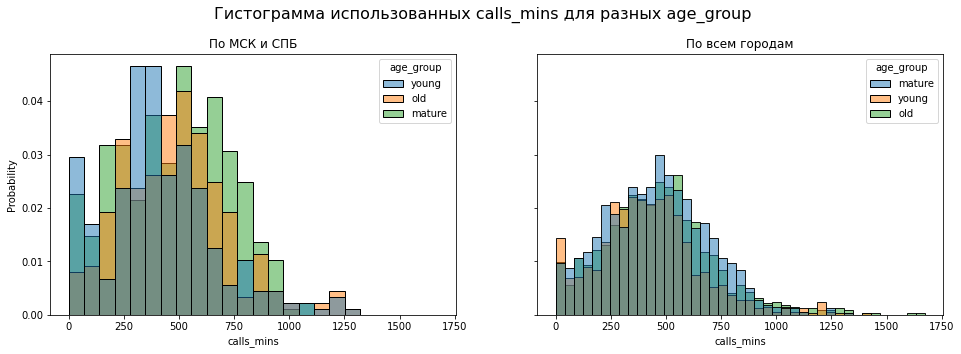

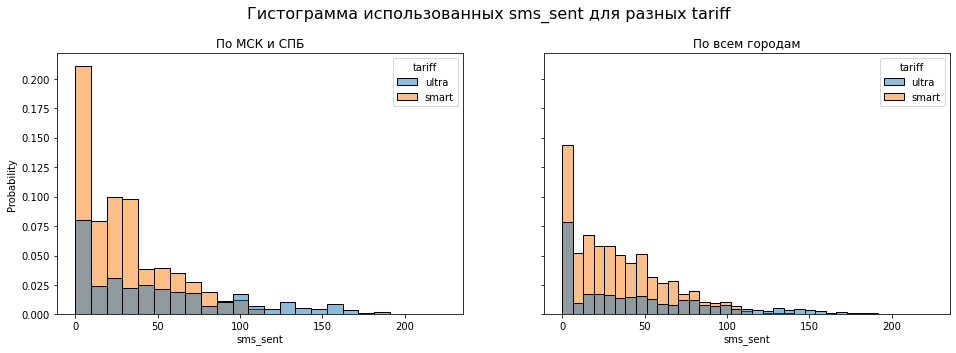

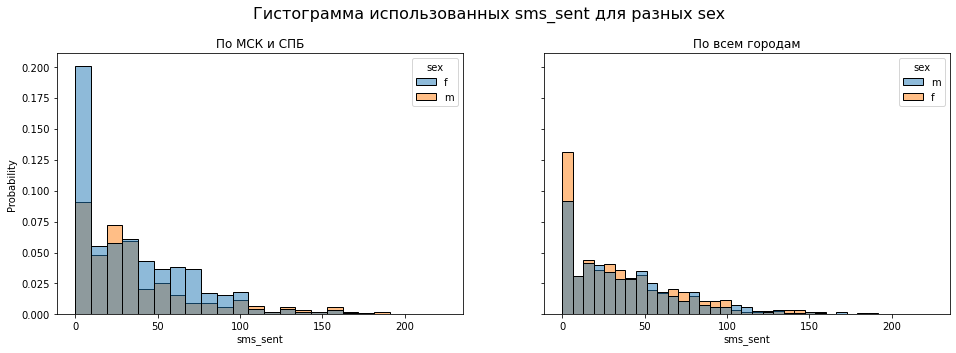

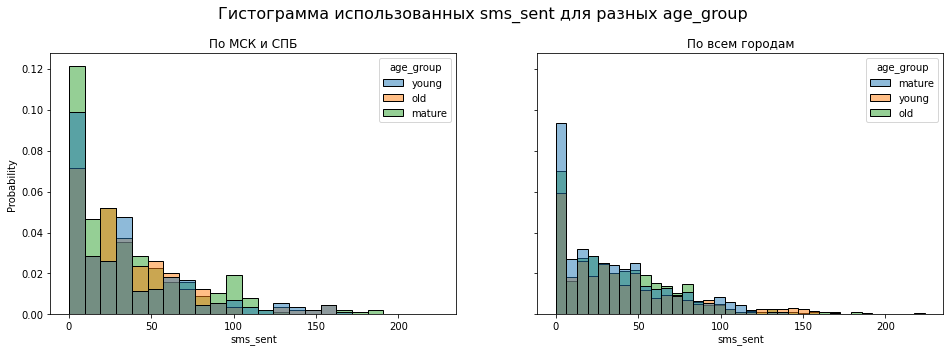

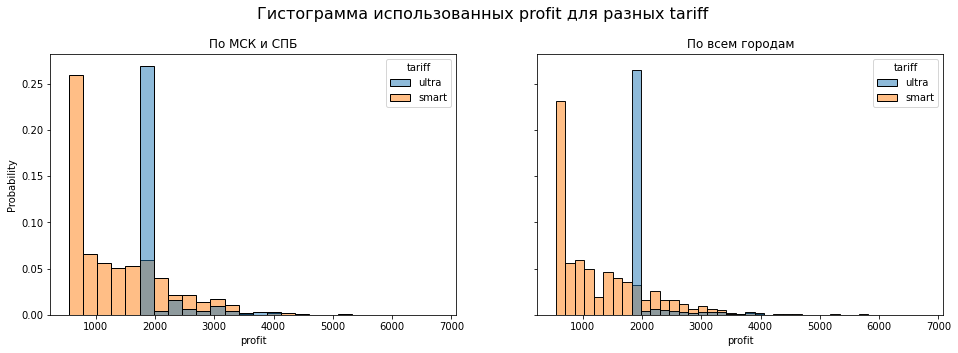

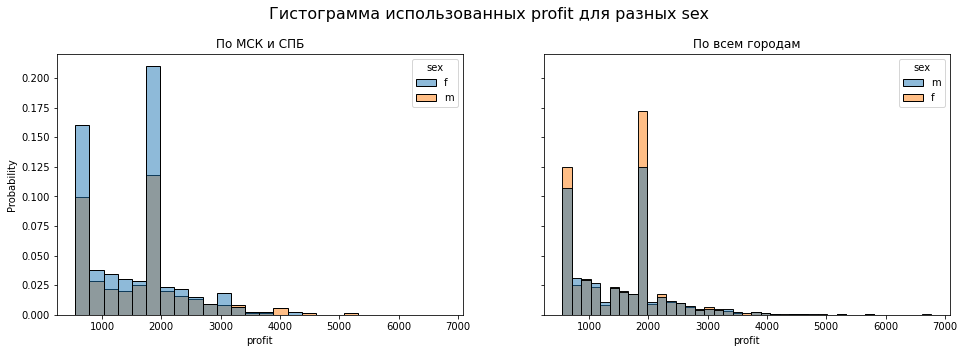

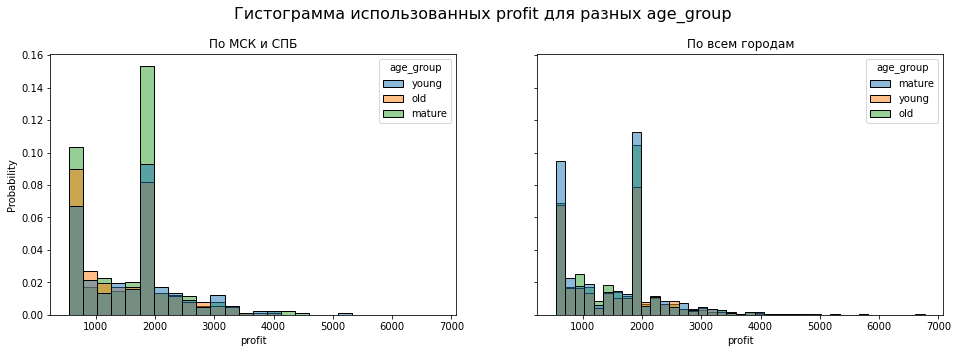

In [34]:
for x in ['gb_used','calls_mins','sms_sent','profit']:
    for hue in ['tariff','sex','age_group']:
        fig, axes = plt.subplots(1, 2, figsize=(16,5), sharex=True, sharey=True)
        
        sns.histplot(data=combo_df[combo_df.city.isin(['Москва','Санкт-Петербург'])],
                     x=x, hue=hue, stat='probability', ax=axes[0])
        sns.histplot(data=combo_df,
                     x=x, hue=hue, stat='probability', ax=axes[1])
        
        fig.suptitle(f'Гистограмма использованных {x} для разных {hue}', fontsize=16)
        axes[0].set_title('По МСК и СПБ')
        axes[1].set_title('По всем городам')
        # Отступ чтобы заголовок не пересекался с подзаголовками.
        plt.subplots_adjust(top=0.85)
        plt.show()

## Среднее количество, медиана, стандартное отклонение и дисперсия

In [35]:
# Построим сводную таблицу.
combo_df.pivot_table(columns='tariff',
                     values=['gb_used','calls_mins','sms_sent','profit'],
                     aggfunc=['mean','median','std','var',st.kurtosis]) \
        .style.format('{:.2f}')

## Выводы

* Распределения преимущественно биноминальные.
* Потребление интернет-трафика близко к форме симметричного нормального распределения. 20 ГБ хватает большинству пользователей независимо от тарифа. При этом в тарифе ultra отсутствует выраженный пик и более высокая дисперсия чем в тарифе smart. В столицах женщины обеспечивают больший объем трафика чем мужчины.
* Пользователи тарифа ultra в среднем общаются больше. Женщины чаще говорят по телефону чем мужчины. Абоненты из категории mature расходуют больше минут на разговоры. Оба тарифа с запасом перекрывают потребности пользователей в общении.
* Количество sms отправленных пользователями не велико (пользователи ultra чаще отправляют sms), при этом женщины предпочитают мессенджеры и соц. сети sms сообщениям. Это заметно в МСК и СПБ. Распределение смещено вправо.
* Большинство абонентов тарифа ultra платит в месяц только абонентскую плату, в то время как пользователи smart в среднем платят в 2 раза больше абонентской платы.

# Проверка гипотез

## Гипотеза 1 - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Зададим пороговое значение alpha.

In [36]:
alpha = 0.05

Для проверки гипотез будем использовать p-value (вероятность получить наблюдаемый результат при условии, что нулевая гипотеза верна).

* Нулевая гипотеза h<sub>0</sub> - средняя выручка тарифов одинакова.
* Альтернативная гипотеза h<sub>1</sub> - средняя выручка тарифов отличается.

In [37]:
# Используем ttest_ind с equal_var=False (так как дисперсии различны).
results = st.ttest_ind(combo_df[combo_df.tariff == 'ultra'].profit,
                       combo_df[combo_df.tariff == 'smart'].profit,
                       equal_var=False)
# Тест двухсторонний. Нам не важно больше или меньше выручка у тарифов.
print('p-значение:', results.pvalue)

p-значение: 4.2606313931076085e-250


In [38]:
print('Среднее для тарифа ultra:', combo_df[combo_df.tariff == 'ultra'].profit.mean())
print('Среднее для тарифа smart:', combo_df[combo_df.tariff == 'smart'].profit.mean())

Среднее для тарифа ultra: 2070.1522842639592
Среднее для тарифа smart: 1289.9735307312696


**Отвергаем нулевую гипотезу. Результат статистически значимый, p-значение фактически равно нулю.**

## Гипотеза 2 - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

* Нулевая гипотеза h<sub>0</sub> - средняя выручка пользователей в Москве и других регионах одинакова.
* Альтернативная гипотеза h<sub>1</sub> - выручка отличается.

In [39]:
results = st.ttest_1samp(combo_df[combo_df.city == 'Москва'].profit,
                         combo_df[combo_df.city != 'Москва'].profit.mean())

print('p-значение:', results.pvalue)

p-значение: 0.4744239730695693


In [40]:
# Альтернативный вариант расчета. Результат получается в диапазоне 0.2-0.8.
results = st.ttest_ind(combo_df[combo_df.city == 'Москва'].profit,
                       # Используем sample чтобы выборки получились одинакового размера.
                       combo_df[combo_df.city != 'Москва'].profit
                           .sample(len(combo_df[combo_df.city == 'Москва'].profit)))

print('p-значение:', results.pvalue)

p-значение: 0.12765525358736915


In [41]:
print('Среднее для Москвы:', combo_df[combo_df.city == 'Москва'].profit.mean())
print('Среднее для регионов:', combo_df[combo_df.city != 'Москва'].profit.mean())

Среднее для Москвы: 1546.7135842880523
Среднее для регионов: 1524.9362274298885


**Не отвергаем нулевую гипотезу о том что средняя выручка одинакова. При этом отмечаем что средние получились почти равные, а значит заметное отличие в выручке не наблюдается.**

# Общий вывод

* Проведен предварительный анализ тарифов на небольшой выборке клиентов, позволяющий определить дальнейшую стратегию телекоммуникационной компании.
* Более выгодным для оператора является тариф ultra, выручка на абонента с него почти в 2 раза выше.
* Пакет услуг в тарифе smart хорошо подобран чтобы стимулировать покупку дополнительных минут и гигабайт, это увеличивает ежемесячный платеж в 2 раза в сравнении с абонентской платой.
* Данные не противоречат гипотезе о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.
* Гипотеза «Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов» подтверждение не получила.